# Panorama Stitching using OpenCV

## 1.2 Feature Detection
First, the images we will create a panorama from are extracted from a ZIP file and converted to grayscale. Then, the images' keypoints and descriptions are found using the Scale-Invariant Feature Transform (SIFT) algorithm. Finally, each image is displayed with its keypoints highlighted.

- Keypoints are distinctive points in an image where significant changes in image properties occur, such as edges or corners. They are crucial for reducing data complexity in images, enabling efficient and focused analysis.
- Descriptors are detailed representations of the image content around keypoints, capturing essential appearance characteristics that are invariant to changes like rotation or scale. They enable robust matching of features across different images.

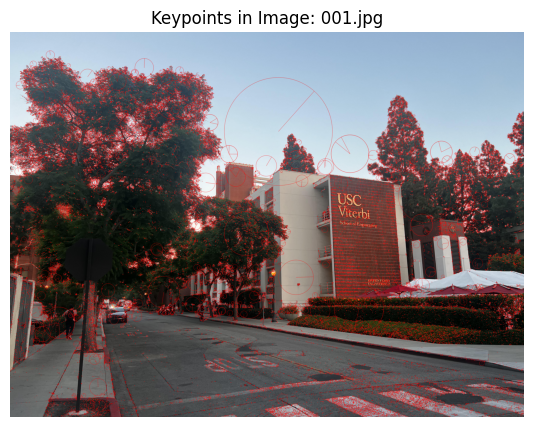

Number of keypoints detected: 75295


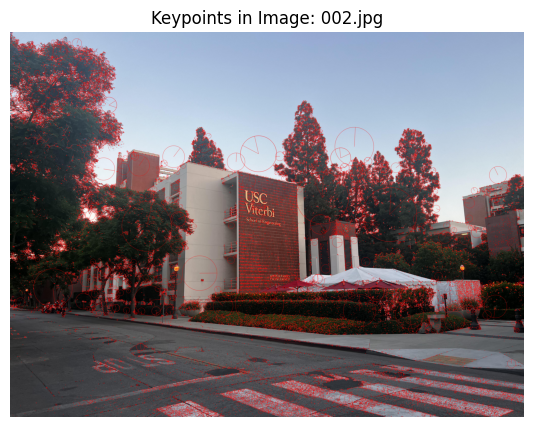

Number of keypoints detected: 67155


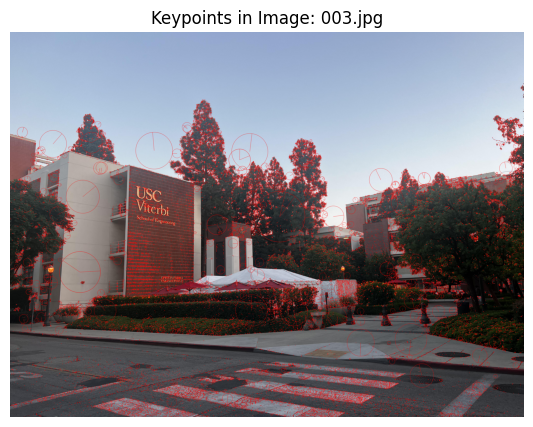

Number of keypoints detected: 52663


In [24]:
import zipfile
import os
import cv2 as cv
from matplotlib import pyplot as plt

def load_and_process_images(directory):
    """Load and detect keypoints and descriptors in images and display results"""
    images = []
    keypoints_all = []
    descriptors_all = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = cv.imread(img_path)
            # Convert image to greyscae
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            # Detect keypoints and descriptors using SIFT
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            # Accumulate for later use
            images.append(img)
            keypoints_all.append(keypoints)
            descriptors_all.append(descriptors)

            # Draw key points on the image for visualization
            img_keypoints = cv.drawKeypoints(img, keypoints, None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.figure(figsize=(10, 5))
            plt.imshow(cv.cvtColor(img_keypoints, cv.COLOR_BGR2RGB))
            plt.title(f"Keypoints in Image: {filename}")
            plt.axis('off')
            plt.show()

            print(f"Number of keypoints detected: {len(keypoints)}")

    return images, keypoints_all, descriptors_all

# Extract image files from zip folder
zip_path = '/content/input_images.zip'
extract_to = '/content/images'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Call function; processed images, keypoint, and descriptors are returned
images, keypoints_all, descriptors_all = load_and_process_images(extract_to)


## 1.3 Feature Matching

Next, feature matching is performed across consecutive images to identify matching points. The brute-force k-nearest neighbors (k-NN) matching algorithm compares every descriptor from one image to all descriptors in the subsequent image, calculating distances to determine the closest matches based on feature similarity. This method exhaustively searches for the best match for each feature descriptor, ensuring a comprehensive comparison between consecutive images.

Afterward, the ratio test is used to filter out less reliable matches. Essentially, true matches should have a distinctly smaller distance than the next best match. So, a ratio test between the distances to the first and second neighbors can help filter out similar distances.

Finally, the top ten matches between a pair of consecutuve images is drawn and displayed along with initial matching and filtering information.


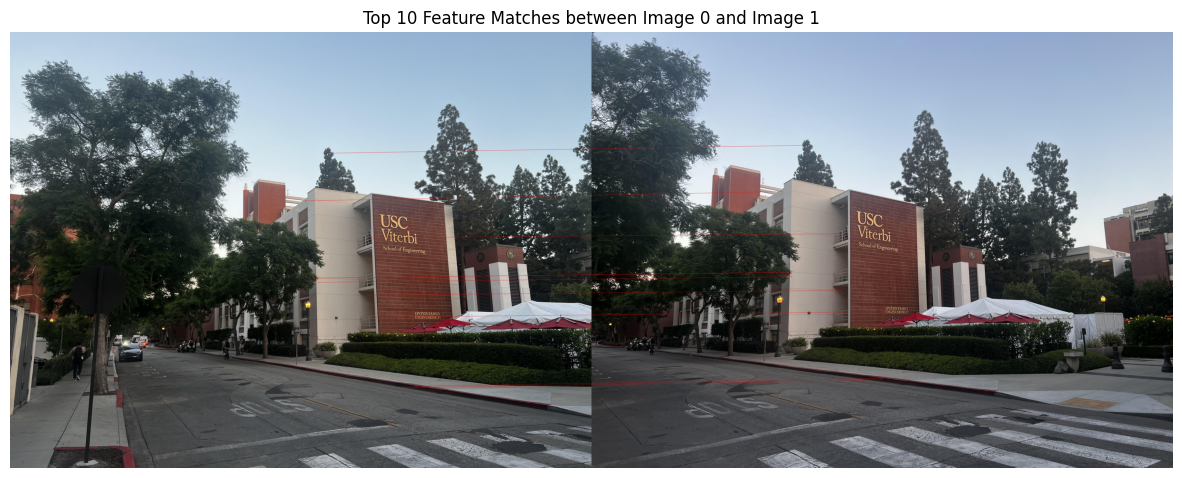

Total matches found: 75295
Good matches after ratio test: 9270


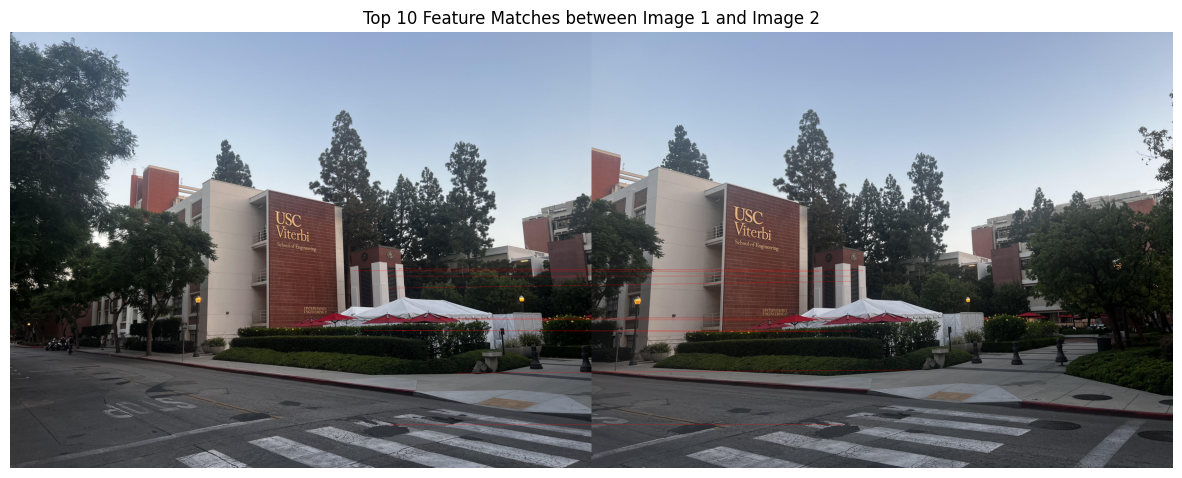

Total matches found: 67155
Good matches after ratio test: 8674


In [18]:
def match_features(images, keypoints_all, descriptors_all):
    """Find and visualize best mnatches between keypoints in successive image pairs"""
    bf = cv.BFMatcher()
    good_matches_all = []

    num_images = len(images)

    for i in range(num_images - 1):
        descriptors1 = descriptors_all[i]
        descriptors2 = descriptors_all[i + 1]

        # Brute-force matcher to find k=2 nearest neighbors for each descriptor in the successive image
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        # Apply ratio test to filter out weak matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append([m])

        # Accumulate lists of good matches between images for later use
        good_matches_all.append(good_matches)

        # Sort good matches in ascending order of distance (lower better)
        flattened_matches = [m[0] for m in good_matches]
        sorted_matches = sorted(flattened_matches, key=lambda x: x.distance)

        # Select top 10 matches for displaying and wrap each in list again to comply with OpenCV formatting
        top10_matches = sorted_matches[:10]
        top10_matches_knn = [[m] for m in top10_matches]

        # Draw top 10 matches between images
        img_matches = cv.drawMatchesKnn(
            images[i], keypoints_all[i],
            images[i + 1], keypoints_all[i + 1],
            top10_matches_knn, None,
            matchColor=(0, 0, 255),
            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        # Display matches visually
        plt.figure(figsize=(15, 10))
        plt.imshow(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
        plt.title(f"Top 10 Feature Matches between Image {i} and Image {i+1}")
        plt.axis('off')
        plt.show()

        # Statistics
        print(f"Total matches found: {len(matches)}")
        print(f"Good matches after ratio test: {len(good_matches)}")

    return good_matches_all

# Call function; sets of good matches between consectutive images are returned
good_matches_all = match_features(images, keypoints_all, descriptors_all)

## 1.4 Compute Homography
Now, we need to compute the homography matrix which will mathematically relate positions in our consecutive images.

First, for each image pair, we retrieve the keypoints and good matches previously identified. We then extract the coordinates of the matched keypoints from both images and prepare them for homography computation by converting them into floating-point numbers and reshaping them into the required format.

Using these corresponding points, we compute the homography matrix with the RANSAC algorithm, which finds the best perspective transformation between the two images while robustly handling outliers or mismatches. This homography matrix captures the geometric relationship between the images, allowing us to map points from one image to the other despite differences in viewpoint or perspective.

Finally, the homography matrix, the number of inlier matches, and the top ten inlier matches with lowest error are printed.

In [19]:
import numpy as np

def compute_homographies(images, keypoints_all, good_matches_all):
    """Calculate homography matrices and identify inlier matches between image pairs"""
    homographies_all = []

    num_pairs = len(good_matches_all)

    for i in range(num_pairs):
        # Extract keypoints and good matches for current image pair
        kp1 = keypoints_all[i]
        kp2 = keypoints_all[i + 1]
        good_matches = good_matches_all[i]

        # Extract coordinates corresponding to keypoints in both images, convert into float, and reshape for homography computation
        src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute homography matrix using RANSAC algorithm
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        # Accumulate computed homography matrices
        homographies_all.append(H)

        # Print matrix and number of inlier matches
        num_inliers = np.sum(mask)
        print(f"Image {i} and Image {i+1}\n")
        print(f"Homography Matrix:\n{H}\n")
        print(f"Number of inlier matches: {int(num_inliers)} out of {len(good_matches)}\n(Matches between keypoints in images that fit computed homography well)\n")

        # Select source and destination points (points determined as inliers by RANSAC)
        src_pts_inliers = src_pts[mask.ravel() == 1]
        dst_pts_inliers = dst_pts[mask.ravel() == 1]

        # Estimate positions of source points in destination image
        projected_pts = cv.perspectiveTransform(src_pts_inliers, H)

        # Calculate Euclidean distance between predicted and actual positions
        errors = np.linalg.norm(projected_pts - dst_pts_inliers, axis=2).ravel()

        # Find top 10 indicies that would sort errors in ascending order
        top10_idx = np.argsort(errors)[:10]

        # Display top 10 inlier points with lowest error
        print(f"Top 10 inlier matches with lowest error:")
        for idx in top10_idx:
            print(f"Match {idx}: Error = {errors[idx]}")
        print("\n")

    return homographies_all

# Call function;
homographies_all = compute_homographies(images, keypoints_all, good_matches_all)

Image 0 and Image 1

Homography Matrix:
[[ 1.47528093e+00 -4.62819220e-02 -1.33342632e+03]
 [ 2.25302869e-01  1.29650792e+00 -5.99816381e+02]
 [ 1.14821958e-04  6.77674899e-06  1.00000000e+00]]

Number of inlier matches: 4712 out of 9270
(Matches between keypoints in images that fit computed homography well)

Top 10 inlier matches with lowest error:
Match 3302: Error = 0.054036904126405716
Match 3486: Error = 0.07428377121686935
Match 3290: Error = 0.16498853266239166
Match 3505: Error = 0.19017912447452545
Match 1519: Error = 0.1931096762418747
Match 3401: Error = 0.19772572815418243
Match 1444: Error = 0.2010314166545868
Match 3339: Error = 0.2031075358390808
Match 1411: Error = 0.2105027735233307
Match 1410: Error = 0.2105027735233307


Image 1 and Image 2

Homography Matrix:
[[ 1.58950028e+00 -6.02160160e-02 -1.60347389e+03]
 [ 2.65764410e-01  1.33575101e+00 -6.25880950e+02]
 [ 1.45378693e-04 -6.71883688e-06  1.00000000e+00]]

Number of inlier matches: 3532 out of 8674
(Matches bet

## 1.5 Stitch into Panorama

Finally, we can create our panorama of the input images. We start by selecting a central "anchor" image to minimize distortion and compute cumulative homographies for all images relative to this anchor. Next, transformation matrices that map each image into the coordinate frame of the anchor image are derived using the homographies calculated previously, effectively aligning overlapping features across the images.

Once the cumulative homographies are calculated, the size of the output panorama is determined by transforming the corner points of each image and finding the minimum and maximum extents needed to encompass all transformed images. Additionally, an offset is applied to adjust for any negative coordinates, ensuring all images fit within the panorama canvas. Then, an empty canvas is created and each image is warped using its cumulative homography, blending them onto the canvas. This blending process overlays the images based on their transformed positions, creating a panorama where the individual images seamlessly merge.

Finally, each warped image and the final stitched panorama is visualized.

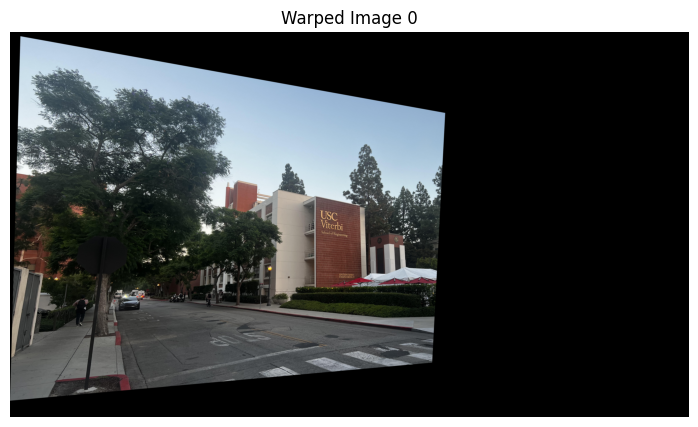

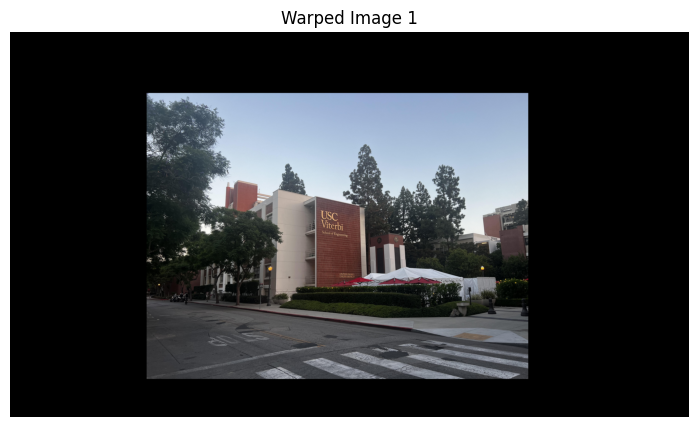

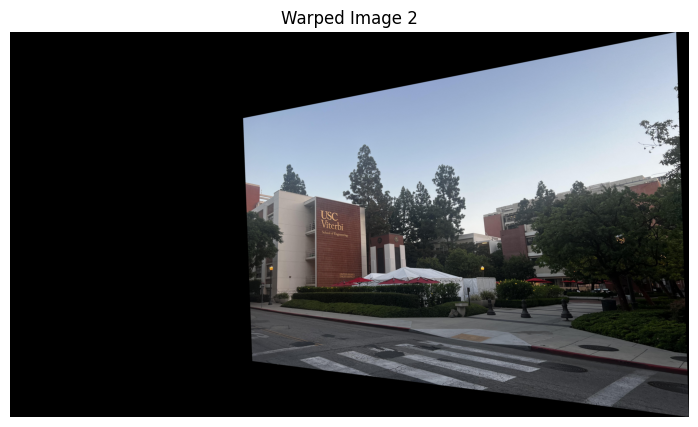

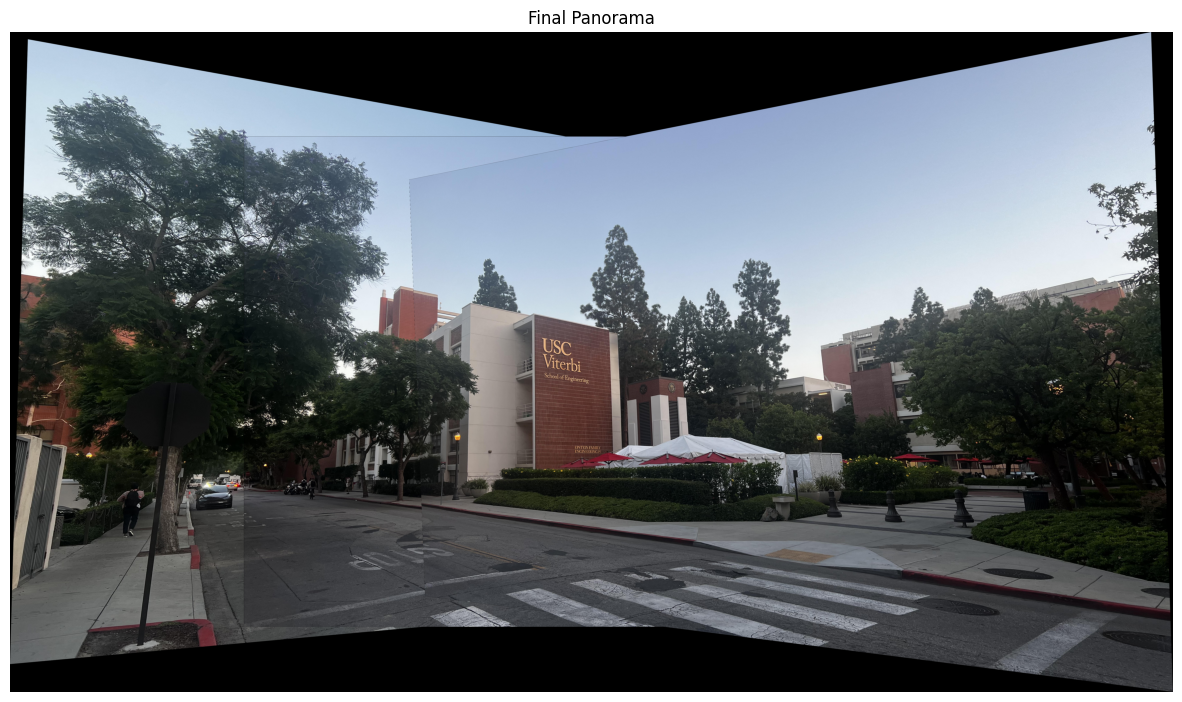

In [23]:
def create_panorama(images, homographies):
    """Stitch series of images into single panoramic image"""
    num_images = len(images)
    anchor_idx = num_images // 2

    # Will store homographies that map each image to panorama frame
    cumulative_homographies = []

    # Initialize identity matrix representing no transformation for anchor image and add to list
    H_anchor = np.eye(3, dtype=np.float32)
    cumulative_homographies.append(H_anchor)

    # Compute homographies for images before the anchor
    H_cumulative = H_anchor.copy()
    for i in range(anchor_idx - 1, -1, -1):
        # Multiply current homography with cumulative homography and chain transformations to map image to anchor frame
        H_cumulative = homographies[i] @ H_cumulative
        # Insert new cumulative homography at beginning of list
        cumulative_homographies.insert(0, H_cumulative)

    # Compute cumulative homographies for images after the anchor
    H_cumulative = H_anchor.copy()
    for i in range(anchor_idx, num_images - 1):
        # Multiply cumulative homography with inverse of current homography and reverse transfromations to map image to anchor frame
        H_cumulative = H_cumulative @ np.linalg.inv(homographies[i])
        # Append cumulative homography to list
        cumulative_homographies.append(H_cumulative)

    # Initialize min and max transformed coordinates
    min_x = min_y = np.inf
    max_x = max_y = -np.inf

    # Loop over all images to find panorama extents
    for i in range(num_images):
        # Retrieve image's height and width
        h, w = images[i].shape[:2]
        # Define image's four corners
        corners = np.array([[0, 0],
                            [w, 0],
                            [w, h],
                            [0, h]], dtype=np.float32).reshape(-1, 1, 2)
        # Transform corner points using cumulative homography to find where each image will be placed in panorama frame
        transformed_corners = cv.perspectiveTransform(corners, cumulative_homographies[i])
        # Check for changes in min and max coordinates and update if needed
        min_x = min(min_x, transformed_corners[:, 0, 0].min())
        min_y = min(min_y, transformed_corners[:, 0, 1].min())
        max_x = max(max_x, transformed_corners[:, 0, 0].max())
        max_y = max(max_y, transformed_corners[:, 0, 1].max())

    # Compute size of output panorama
    output_width = int(np.ceil(max_x - min_x))
    output_height = int(np.ceil(max_y - min_y))

    # Define offset panorama to adjust for negative coordinates
    offset_h = np.array([[1, 0, -min_x],
                         [0, 1, -min_y],
                         [0, 0, 1]], dtype=np.float32)

    # Create panorama canvas
    panorama = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    # Warp each image
    for i in range(num_images):
        # Combine cumulative and offset homographies
        H = offset_h @ cumulative_homographies[i]

        # Warp image using combined homography
        warped_image = cv.warpPerspective(images[i], H, (output_width, output_height))

        # Create mask of warped image to identify non-zero regions
        mask_warped = cv.warpPerspective(np.ones_like(images[i], dtype=np.uint8) * 255, H, (output_width, output_height))
        mask = cv.cvtColor(mask_warped, cv.COLOR_BGR2GRAY)

        # Blend warped image onto panorama by overwriting panorama's pixels with those from warped image
        panorama[mask > 0] = warped_image[mask > 0]

        # Visualize warped images
        plt.figure(figsize=(10, 5))
        plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
        plt.title(f"Warped Image {i}")
        plt.axis('off')
        plt.show()

    # Visualize final panorama
    plt.figure(figsize=(15, 10))
    plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
    plt.title("Final Panorama")
    plt.axis('off')
    plt.show()

    return panorama

# Call function to create and display panorama
panorama = create_panorama(images, homographies_all)


## Final Observations

1. The SIFT algorithm successfully detected a substantial number of keypoints in each image and the visualization showed a good distribution across various regions in the image.

2. The brute-force k-nearest neighbors matcher effectively found correspondences between descriptors of consecutive images. The ratio test filtered out many false matches, honing in on the best matches and the top ten matches matched points well in consecutive images.

3. The RANSAC algorithm proved effective in mitigating the impact of outliers and mismatches and provided an accurate homography matrix as shown by a high number of inlier mmatches.

4. Computing cumulative homographies relative to the anchor image successfully aligned all images into the panorama frame. By transforming image corners and computing the canvas size, all warped images were fully captured in the final panorama.

5. There are visible seams in the final panorama and transition points between consecutive images are not perfectly aligned, possibly due to the simple blending method used (direct pixel replacement). Additional processing or more complex techniques could enhance the visual quality.

6. Overall, the combination of feature detection, matching, homography computation, and image warping provided a funcitonal pipeline for panorama creation.